In [ ]:
!pip install transformers


In [ ]:

from transformers import (
   AutoConfig,
   AutoTokenizer,
   TFAutoModelForSequenceClassification,
   AdamW
)
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

## Language models, transformers y fine-tuning


Los modelos de lenguaje han facilitado y democraizado el desarrollo del NLP y el Text Mining. Los modelos de lenguaje son capaces de _entender_ , al menos a nivel estadístico, la lengua en la que han sido entrenados. Aunque no son capaces de realizar la mayoría de las tareas, si que pueden ser afinados (_fine-tuned_) para que realicen tareas específicas, aprovechándose al máximo del conocimiento del idioma en el que fueron entrenados. 

Los modelos de lenguaje se sostienen sobre la arquitectura **Transformers**. GPT fue el primer modelo de lenguaje pre-entrenado con esta arquitectura, con capacidades de afinamiento. Desde entonces se han publicado modelos como BERT, GPT-2, XLM, DistilBERT, T5... que han sido entrenados con mayores volúmenes de textos y son capaces de realizar las tareas con mayor rendimiento. 


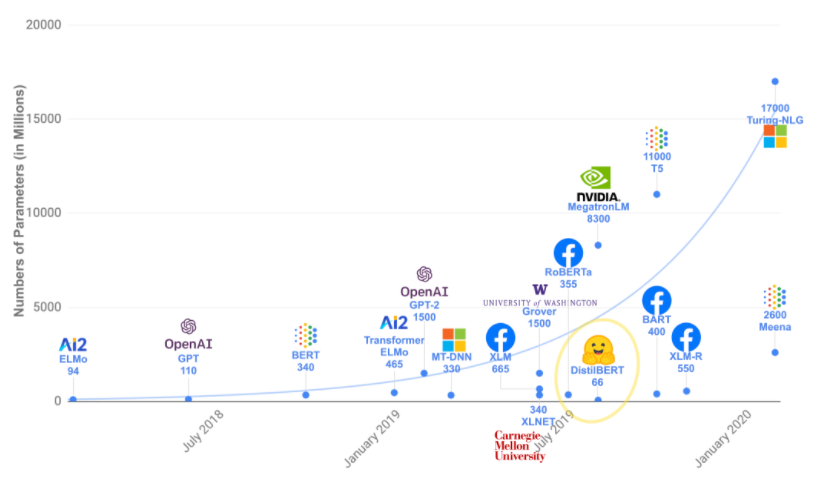

Los modelos de lenguaje son publicados por organismos con grandes capacidades de cálculos como centros de investigación, universidades o empresas tecnológicas; para que puedan ser afinados por la comunidad cientifico-tecnológica para múltiples propósitos.

El proceso de afinar los modelos actualmente puede ser **muy** sencillo gracias a librarías como [Transformers](https://huggingface.co/docs/transformers/index), desarrollada por el equipo de HuggingFace🤗. Esta librería permite seleccionar modelos de un hub público, preparar tus datos, y afinar un modelo para realizar la tarea que desees. Esta librería tiene un gran apoyo de la comunidad, que fomenta la reutilización y apertura tanto de los datos como de los modelos construidos. Gracias a todo esto es mucho más fácil que nunca conseguir rendimientos state-of-the-art sin disponer de grandes volúmenes de datos.


## 🤗 HuggingFace Transformers

HuggingFace está construido sobre el objeto ``pipeline()``. Esta función permite abstraerse de la complejidad del código y focalizar los esfuerzos en la atarea que se quiere conseguir realizar.

Pipeline permite, entre otras cosas, cargar pipeline pre-entrenada para diferentes tareas como análisis de sentimiento, text-generation o traducción de forma muy sencilla.

En primer lugar se cargaría el módulo

In [ ]:
from transformers import pipeline



*   Análisis de sentimiento



In [ ]:
sent_class = pipeline("sentiment-analysis")
sent_class("I hate that rythm, but I love the guitar sound")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.999613344669342}]

*   Generación de texto


In [ ]:
gen_text = pipeline("text-generation", model="distilgpt2")
gen_text("I hate that rythm, but", max_length=50)

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "I hate that rythm, but don't blame me for that.\nIt would have been nice if I'd stayed on the keyboard myself.\nAdvertisements"}]

## Fine-tuning para análisis de sentimiento

### Preparación de datos

En este caso, vamos a utilizar HuggingFace para hacer el fine-tuning de un modelo pre-entrenado para que realice una tarea de clasificación. 
Para empezar, descargaremos los datos etiquetados de la cuenta de github con datos para esta clase:

In [ ]:
path_to_tsv = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/datos_twitter_master.tsv"
df = pd.read_csv(path_to_tsv,"\t")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


Para seleccionar el modelo podemos acceder al [hub de modelos de HuggingFace](https://huggingface.co/models). Ahí podemos filtrar por modelos capaces de realizar distintos tipos de tareas que pueden ser descargados y utilizados directamente, o afinados para un funcionamiento mejor con nuestros datos.

En este caso trabajaremos con el modelo bert-base-uncased, uno de los más populares y consolidados.

In [ ]:
model_name = 'bert-base-uncased'

Los datos necesitan ser procesados para que puedan ser introducidos al modelo Para ello utilizamos el tokenizador del modelo pre-entrenado con el que estamos trabajando. 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

A continuación, dividimos nuestro dataset para el proceso. Primero, seleccionamos los textos y etiquetas en variables separadas.

In [ ]:
texts = df.tweet_text.values  # an array of strings
labels = df.molestia.values  # an array of integers

Despues dividimos el conjunto de datos en Train-Validation (90%) y Test (10%).

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=.1)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

Antes de preprocesar la entrada, necesitamos definir la longitud de la secuencia (longitud maxima del documento en tokens) y el Batch size. En Colab, hay limitaciones (batch = 8 y secuencia=96). Si se reduciera el batch se podría incrementar el tamaño, pero en este caso nos es indiferente.

In [ ]:
max_seq_length = 96 #@param {type: "integer"}
train_batch_size =  8#@param {type: "integer"} 
eval_batch_size = 8 #@param {type: "integer"}
test_batch_size = 8 #@param {type: "integer"}

Preprocesamos nuestros datos utilizando el tokenizador definido previamente:

In [ ]:
train_encodings = tokenizer(train_texts.tolist(), truncation=True, max_length=max_seq_length, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, max_length=max_seq_length, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, max_length=max_seq_length, padding=True)

Se observa que el texto se sustituye por valores numéricos en un vector de tamaño ``max_seq_length´´

In [ ]:
test_encodings

Después generamos los tensores:

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

### Entrenamiento

En este fine-tuning utilizando [TFAutoModelForSequenceClassification](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodelforsequenceclassification) vamos a:



*   Especificar el número de clases de salida
*   Especificar el learning_rate, número de epocas.
*   Especificar optimizadores, Loss Functions y métricas de evaluación
*   Entrenar el modelo




In [ ]:
# Numero de etiquetas
num_labels = 2
# Numero de muestras de entrenamiento y validación
num_train_examples = len(train_dataset)
num_dev_examples = len(val_dataset)
# Train steps
train_steps_per_epoch = int(num_train_examples / train_batch_size)
dev_steps_per_epoch = int(num_dev_examples / eval_batch_size)
# LEarning rate y epochs
learning_rate = 2e-5
num_epochs = 1
# Preparción del train y val dataset en batches con la configuración especificada.
train_dataset = train_dataset.shuffle(100).batch(train_batch_size)
val_dataset = val_dataset.shuffle(100).batch(eval_batch_size)

In [ ]:
# Configuración del AutoModel para clasificación de secuencias (nuestro caso)
config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, config=config)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Building/compilación del modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Entrenamos el modelo compilado, que realmente será un fine-tuning:

In [ ]:
history = model.fit(train_dataset, 
  epochs=num_epochs,
  steps_per_epoch=train_steps_per_epoch,
  validation_data=val_dataset,
  validation_steps=dev_steps_per_epoch)

91/91 [==============================] - 38s 178ms/step - loss: 0.4407 - accuracy: 0.8352 - val_loss: 0.3587 - val_accuracy: 0.8587


Si hubieramos hecho más de una época, podríamos hacer esta gráfica:

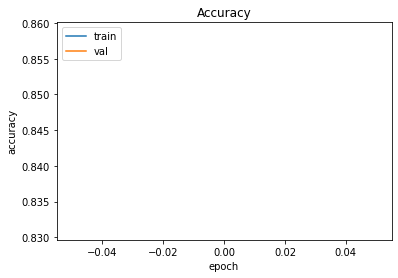

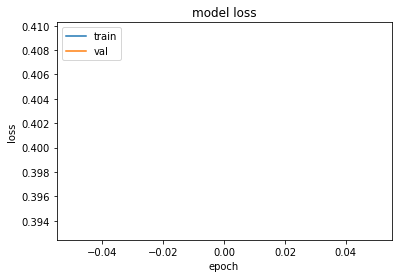

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Test

Vamos a comprobar el resultado final del modelo. TAmbién vamos a hacer un classification report para ver FP y FN, y comprobar que las métricas en test son similares a las de development.

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset.batch(test_batch_size),verbose=2)
print('\nTest accuracy:', test_acc)

13/13 - 3s - loss: 0.4644 - accuracy: 0.7941 - 3s/epoch - 238ms/step

Test accuracy: 0.7941176295280457


Hacemos predicción del test set con el modelo (cogemos logits) y argmax.


In [ ]:
import numpy as np
y_pred = model.predict(test_dataset.batch(eval_batch_size)).logits
y_pred = np.argmax(y_pred,axis=1)

Las true labels son:

In [ ]:
y_true = [y for x,y in test_dataset]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81        64
           1       0.65      0.95      0.77        38

    accuracy                           0.79       102
   macro avg       0.81      0.83      0.79       102
weighted avg       0.84      0.79      0.80       102



También podemos predecir cualquier frase o tweet que quisiéramos:


In [ ]:
#@markdown >Escribe el texto que quieras clasificar
input_text1 = 'I hate that noise'  #@param {type: "string"}
input_text2 = 'I feel so lucky that today is about the quietest its ever been here. Fewer copters, no construction noise. Ahhhhhhhhh #selfcare https://t.co/7Ka4M6wFQv' 
# Tokenizamos esa frase (encode)
input_ids1 = tf.constant(tokenizer.encode(input_text1, add_special_tokens=True))[None, :]
input_ids2 = tf.constant(tokenizer.encode(input_text2, add_special_tokens=True))[None, :]

# PRedecimos
pred1 = model.predict(input_ids1)["logits"]
pred2 = model.predict(input_ids2)["logits"]

# Print logits
print(pred1)
print(pred2)


preds1 = np.argmax(pred1,axis=1)
preds2 = np.argmax(pred2,axis=1)

# label_mapping = {0:"no molesto",1:"molesto"}

print("Clase texto 1: {}".format(preds1))
print("Clase texto 2: {}".format(preds2))

[[-0.48373404  0.5705178 ]]
[[ 0.62504935 -0.30503508]]
Clase texto 1: [1]
Clase texto 2: [0]


In [ ]:
tf.math.softmax(pred2)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.24515806, 0.7548419 ]], dtype=float32)>